# Structure Function Turbulent Data

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

# verify cuda
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# device = 'cpu'
print('Torch in running on', device)

Torch in running on cuda:0


In [28]:
from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp

from turboflow.callbacks import RefineSolution

## Input data

Original size 256
Y shape (256, 256, 2)
Y min, max: -2.316562 2.692522
after normalization, Y min, max: -0.8603688289269317 1.0
Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION


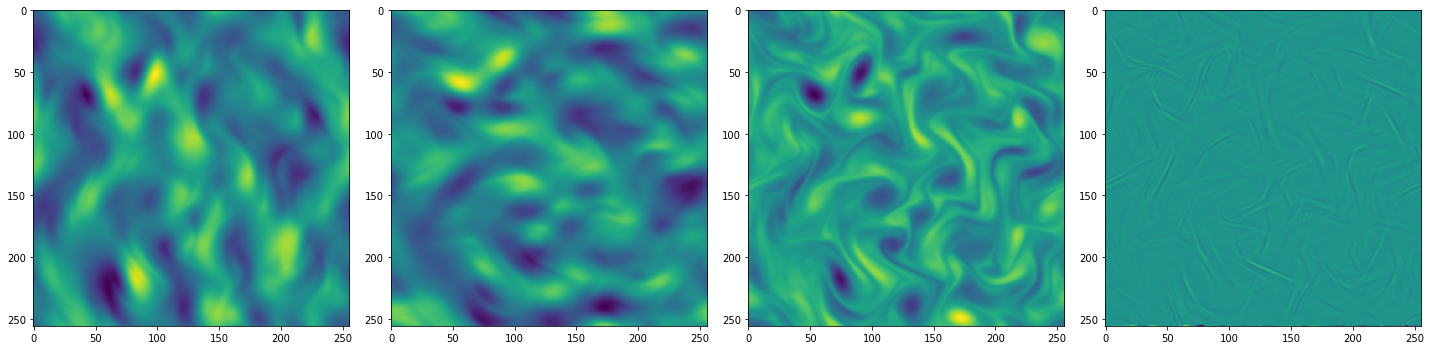

In [4]:
## SET UP DATA
path_to_data = '../data/2021-Turb2D_velocities.npy'
IMGs = np.load(path_to_data)
img_index = 55
X = IMGs[img_index,:,:,:2] / 255
U = IMGs[img_index,:,:,2:]
t = np.arange(0,IMGs.shape[0],step=0.01)
Re = 3900

original_size = X.shape[0]
print('Original size', original_size)

# normalize output
y = U.copy()
print('Y shape', y.shape)
print('Y min, max:', np.min(y), np.max(y))
y = y / np.max(np.abs(y))
print('after normalization, Y min, max:', np.min(y), np.max(y))

ytest = y.copy()
Xtest = X.copy()

W = phy.compute_vorticity(U[:,:,0],U[:,:,1])
D = phy.compute_divergence(U[:,:,0],U[:,:,1])

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(U[:,:,0])
plt.subplot(142)
plt.imshow(U[:,:,1])
plt.subplot(143)
plt.imshow(W)
plt.subplot(144)
plt.imshow(D)
plt.tight_layout()
plt.show()

Xtrain shape: (42, 42, 2)
ytrain shape: (42, 42, 2)


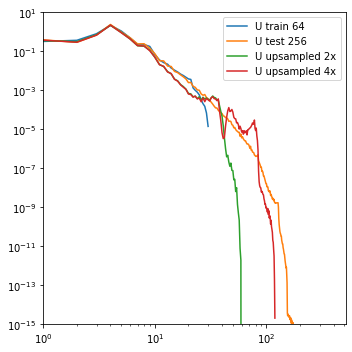

In [5]:
# downsampled resultion
scale = 1/6
coords = np.linspace(0, 1, int(original_size * scale), endpoint=False)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
Xtrain = coords
print('Xtrain shape:', Xtrain.shape)

y1ds = dsp.interpolate2D(X, y[:,:,0], scale=scale)[:,:,None]
y2ds = dsp.interpolate2D(X, y[:,:,1], scale=scale)[:,:,None]
ytrain = np.concatenate([y1ds, y2ds], axis=-1)
print('ytrain shape:', ytrain.shape)

# upsampled resolution
yup2 = dsp.interpolate2D(Xtrain, ytrain[:,:,0], scale=2)[:,:,None]
yup4 = dsp.interpolate2D(Xtrain, ytrain[:,:,0], scale=4)[:,:,None]


fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(ytrain[:,:,0]))), phy.powerspec(ytrain[:,:,0]), label='U train 64')
axs.loglog(np.arange(len(phy.powerspec(ytest[:,:,0]))), phy.powerspec(ytest[:,:,0]), label='U test 256')
axs.loglog(np.arange(len(phy.powerspec(yup2[:,:,0]))), phy.powerspec(yup2[:,:,0]), label='U upsampled 2x')
axs.loglog(np.arange(len(phy.powerspec(yup4[:,:,0]))), phy.powerspec(yup4[:,:,0]), label='U upsampled 4x')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.tight_layout()
plt.show()

# Dataset

In [6]:
class MyDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):

        assert np.max(np.abs(y)) <= 1
        assert np.max(np.abs(X)) <= 1

        'Initialization'
        print('X shape', X.shape)
        print('y shape', y.shape)
        try:
            assert X.shape[0] == y.shape[0]
            assert X.shape[1] == y.shape[1]
        except:
            print('*** Dimension error ***')
            print('X', X.shape)
            print('y', y.shape)
            
        H, W, Cin = X.shape
        H, W, Cout = y.shape
        
        # reshape s.t. B = H*W of query points
        X = X.reshape(H*W, Cin)
        y = y.reshape(H*W, Cout)
        
        self.size = H*W
        # convert to torch and add an empty dimension for the batch
        self.inputs = torch.from_numpy(X).float() #XY x 2 (x,y)
        self.target = torch.from_numpy(y).float()  #XxYx3 (RGB)
        
        assert self.inputs.shape[0] == self.target.shape[0]
        assert self.inputs.shape[1] == self.target.shape[1]
        
        print(self.inputs.shape)
        print(self.inputs.shape)

    def __len__(self):
        'Denotes the total number of samples'
        return self.size

    def __getitem__(self, idx):
        'Generates one sample of data'
        # Load data and get label
        X = self.inputs[idx,...]
        y = self.target[idx,...]

        return X, y


class DataModule(pl.LightningDataModule):
    def __init__(self, name, train_data, val_data, test_data, 
                 batch_size=2000, num_workers=8, shuffle=False):
        
        super().__init__()
        self.name = name
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        
    def prepare_data(self):
        self.train_dataset = MyDataset(self.train_data[0], self.train_data[1])
        self.val_dataset = MyDataset(self.val_data[0], self.val_data[1])
        self.test_dataset = MyDataset(self.test_data[0], self.test_data[1])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
Train
torch.Size([4096, 2]) torch.Size([4096, 2])


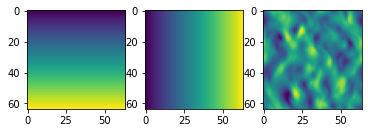

Validation
torch.Size([4096, 2]) torch.Size([4096, 2])


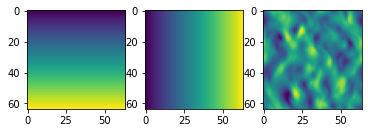

In [7]:
low_scale = 1/4
curr_res = int(original_size * low_scale)

Xlow = np.concatenate([
            dsp.interpolate2D(X, Xtest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, Xtest[:,:,1], scale=low_scale)[:,:,None]], 
       axis=-1)
ylow = np.concatenate([
            dsp.interpolate2D(X, ytest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, ytest[:,:,1], scale=low_scale)[:,:,None]],
        axis=-1)

dm = DataModule(
    name = 'Turbo2D-%d' % img_index,
    train_data=[Xlow, ylow],
    val_data=[Xlow, ylow],
    test_data=[Xlow, ylow],
    batch_size = 128**2,
    shuffle=False,
)

## test
dm.prepare_data()
print('Train')
for batch in dm.train_dataloader():
    x, y = batch
    print(x.shape, y.shape)
    
    plt.subplot(131)
    xshow = x.cpu().detach().numpy().squeeze()
    plt.imshow(xshow.reshape(curr_res,curr_res,2)[:,:,0])
    plt.subplot(132)
    xshow = x.cpu().detach().numpy().squeeze()
    plt.imshow(xshow.reshape(curr_res,curr_res,2)[:,:,1])
    plt.subplot(133)
    yshow = y.cpu().detach().numpy().squeeze()
    plt.imshow(yshow.reshape(curr_res,curr_res,2)[:,:,0])
    plt.show()

print('Validation')
for batch in dm.val_dataloader():
    x, y = batch
    print(x.shape, y.shape)
    plt.subplot(131)
    xshow = x.cpu().detach().numpy().squeeze()
    plt.imshow(xshow.reshape(curr_res,curr_res,2)[:,:,0])
    plt.subplot(132)
    xshow = x.cpu().detach().numpy().squeeze()
    plt.imshow(xshow.reshape(curr_res,curr_res,2)[:,:,1])
    plt.subplot(133)
    yshow = y.cpu().detach().numpy().squeeze()
    plt.imshow(yshow.reshape(curr_res,curr_res,2)[:,:,0])
    plt.show()

# Model

## RFF on batch

In [150]:
class Fourier(nn.Module):
    
    def __init__(self, nfeat, scale):
        super(Fourier, self).__init__()
        self.b = nn.Parameter(torch.randn(2, nfeat)*scale, requires_grad=False)
        self.pi = 3.14159265359

    def forward(self, x):
        x = torch.einsum('bc,cf->bf', 2*self.pi*x, self.b.to(x.device))
        return torch.cat([torch.sin(x), torch.cos(x)], -1)

    
def LinearReLU(n_in, n_out):
    # do not work with ModuleList here either.
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU()
    )
    return block

    
class MLP(nn.Module):
    
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        layers = []
        num_layers = len(dim_layers)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(LinearReLU(dim_layers[l], dim_layers[l+1]))
            
        blocks.append(nn.Linear(dim_layers[-2], dim_layers[-1]))
        blocks.append(nn.Tanh())
        self.network = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.network(x)

    
class RFFNet_pl(pl.LightningModule):
    
    def __init__(self, name, dim_mpl_layers, f_nfeatures, f_scale, random_matrix=None, lam_pde=1e-4):
        super(RFFNet_pl, self).__init__()
        self.name = name
        self.automatic_optimization = True
        
        # regression/pinn network       
        self.rff = Fourier(f_nfeatures, f_scale) # directly the random matrix 'cause of checkpoint and load
        self.mlp = MLP(dim_mpl_layers)
        
        # PINN losses
        self.lam_pde = lam_pde
        
        # other params
        # self.mode = mode # pre_train with adam, fine_tune with bsgf
        
        # for loading from checkpoints
        self.save_hyperparameters('name', 'dim_mpl_layers', 'f_nfeatures', 'f_scale', 'lam_pde')
    
    def forward(self, x): # x := BxC(Batch, InputChannels)
        ## Fourier features
        x = self.rff(x) # Batch x Fourier Features
        ## MLP
        x = self.mlp(x)
        return x

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, x_true = batch
        x.requires_grad_(True) # for computing the grad in the loss_pde
        x_pred = self.forward(x)
        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)
        # pde loss: div(u) = 0
        if self.lam_pde > 0:
            u, v = torch.split(x_pred,1,-1)
            du_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
            dv_y = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
            div_u = du_x[...,0] + dv_y[...,1]
            loss_pde = torch.norm(div_u)
            loss = loss_rec + self.lam_pde*loss_pde
        else:
            loss = loss_rec
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        self.log('train_loss_data', loss_rec)
        return loss

    
    def validation_step(self, batch, batch_idx):
        # enable gradient
        torch.set_grad_enabled(True)
        x, x_true = batch
        x.requires_grad_(True) # for computing the grad in the loss_pde
        x_pred = self.forward(x)
        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)
        # pde loss: div(u) = 0
        if self.lam_pde > 0:
            u, v = torch.split(x_pred,1,-1)
            du_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
            dv_y = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
            div_u = du_x[...,0] + dv_y[...,1]
            loss_pde = torch.norm(div_u)
            loss = loss_rec + self.lam_pde*loss_pde
        else:
            loss = loss_rec
        self.log('valid_loss', loss, on_step=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {"optimizer": optimizer}
#                 "lr_scheduler": scheduler, 
#                 "monitor": "valid_loss"}

In [151]:
# LIST OF MODELS
n_features = 256
dim_mlp_layers = [2*n_features] + 3*[256] + [2]
scale = 10

models_hparams = {
    'RFFNet' : {
        'name' : 'RFFNet',
        'lam_pde' : 0,
    },
    'PhyRFFNet' : {
        'name' : 'PhyRFFNet',
        'lam_pde' : 1e-4,
    }
}

In [168]:
curr_model_name = 'RFFNet'
model = RFFNet_pl(curr_model_name, 
                  dim_mlp_layers, 
                  n_features, 
                  scale, 
                  lam_pde=models_hparams[curr_model_name]['lam_pde'])
print(model)

RFFNet_pl(
  (rff): Fourier()
  (mlp): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=256, out_features=2, bias=True)
      (4): Tanh()
    )
  )
)


In [ ]:
checkpoint_dir = '../torch_checkpoints/'

early_stop_callback = EarlyStopping(monitor='valid_loss')
refine_sol_callback = RefineSolution(thr=1e-7)
checkpoint_callback = ModelCheckpoint(
    monitor="valid_loss",
    dirpath=checkpoint_dir,
    filename="%s-%s-{epoch:02d}-{valid_loss:.5f}" % (dm.name, model.name),
    save_top_k=3,
    mode="min",
)

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=10, 
                     max_epochs=int(10e3), 
                     callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model, dm)

# save models
best_model_path = checkpoint_callback.best_model_path
print(checkpoint_callback.best_model_path)
torch.save(model.state_dict(), best_model_path.replace('ckpt','torch'))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rff  | Fourier | 512   
1 | mlp  | MLP     | 263 K 
---------------------------------
263 K     Trainable params
512       Non-trainable params
263 K     Total params
1.056     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [165]:
fname_phy = 'Turbo2D-55-PhyRFFNet-epoch=619-valid_loss=0.00560.torch'
fname_rff = ''

best_model_phy = RFFNet_pl(models_hparams['PhyRFFNet']['name'], 
                  dim_mlp_layers, 
                  n_features, 
                  scale, 
                  lam_pde=models_hparams['PhyRFFNet']['lam_pde'])
best_model_phy.load_state_dict(torch.load(checkpoint_dir + fname))
print(best_model_phy.state_dict())

OrderedDict([('rff.b', tensor([[ -8.4924,  -0.7952, -19.1288,  -1.9991, -15.7687,  -4.0969,   5.2804,
           6.1916,   2.9402,   4.5249,   3.5633, -15.2345,   4.1050,  -2.4000,
           0.5970,   7.5650,   1.5458, -10.5158,  16.0475,   5.4093,  -1.7614,
           0.1318,  -9.9801,   6.2623,   9.6118,  -6.7286, -20.7514,   0.4861,
         -11.6188,  -2.0119, -14.8099,   2.5400,  -0.1223,   6.2407, -16.0086,
           2.9257,  -6.7779,   2.5947,  20.8967,  11.4420,  13.5858, -24.5200,
          -2.7582,   6.8428,  -9.2173,   0.6077,  -6.1825,  -6.2627,   0.5943,
           4.3594,   4.0293, -21.5993,   2.3957, -18.3886,   0.3831,  14.9563,
          -6.0674,  12.8116,   5.0721,  -4.9394,   2.2754,  -2.8357,   4.7561,
         -11.6119, -22.6265, -11.9504,   4.2880,   3.6693,   4.0451,   3.9385,
           6.8075, -12.9114,  10.0719,  18.8213,   6.4193,  -2.9768,   6.6986,
          -0.0640,   1.8403,  15.8923, -12.9666,  -4.2577,  -5.6950, -10.0224,
         -15.9091,  -8.5011, 

In [85]:
# best_model_fname_rff = 'Turbo2D-55-RFFNet-epoch=369-valid_loss=0.00000.ckpt'
# best_model_fname_phy = 'Turbo2D-55-PhyRFFNet-epoch=509-valid_loss=0.00673.ckpt'

# best_model_rff = RFFNet_pl(models_hparams['RFFNet']['name'], 
#                       dim_mlp_layers, 
#                       n_features, 
#                       scale, 
#                       lam_pde=models_hparams['RFFNet']['lam_pde'], device=device)
# best_model_phy = RFFNet_pl(models_hparams['PhyRFFNet']['lam_pde'], 
#                       dim_mlp_layers, 
#                       n_features, 
#                       scale, 
#                       lam_pde=models_hparams['PhyRFFNet']['lam_pde'], device=device)

# best_model_rff.load_state_dict(torch.load(checkpoint_dir + best_model_fname_rff.replace('ckpt','torch')))
# best_model_phy.load_state_dict(torch.load(checkpoint_dir + best_model_fname_phy.replace('ckpt','torch')))

# best_model_rff.to(device)
# best_model_phy.to(device)

In [166]:
model.eval()
best_model.eval()

print(model(torch.Tensor([[.1,.2]])))
print(best_model(torch.Tensor([[.1,.2]])))

tensor([[0.3934, 0.1149]], grad_fn=<TanhBackward>)
tensor([[0.3934, 0.1149]], grad_fn=<TanhBackward>)


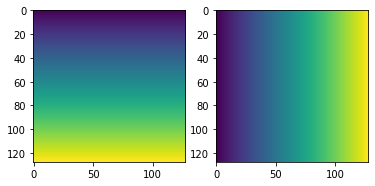

(16384, 2)


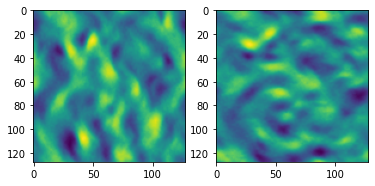

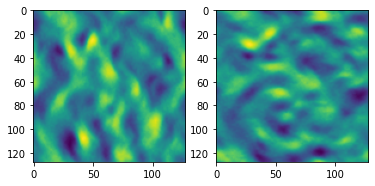

In [167]:
# TEST
ngrid = 128
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp

plt.subplot(121)
plt.imshow(coords[:,:,0])
plt.subplot(122)
plt.imshow(coords[:,:,1])
plt.show()

coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().to(device)

model.to(device)
model.eval()

best_model.to(device)
best_model.eval()

ypred_rff = best_model(x).cpu().detach().numpy().squeeze()
ypred = model(x).cpu().detach().numpy().squeeze()

plt.subplot(121)
plt.imshow(ypred_rff.reshape(ngrid,ngrid,2)[:,:,0])
plt.subplot(122)
plt.imshow(ypred_rff.reshape(ngrid,ngrid,2)[:,:,1])
plt.show()

plt.subplot(121)
plt.imshow(ypred.reshape(ngrid,ngrid,2)[:,:,0])
plt.subplot(122)
plt.imshow(ypred.reshape(ngrid,ngrid,2)[:,:,1])
plt.show()

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(ytrain[:,:,0]))), phy.powerspec(ytrain[:,:,0]), label='U train 64')
axs.loglog(np.arange(len(phy.powerspec(ytest[:,:,0]))), phy.powerspec(ytest[:,:,0]), label='U test 256')
axs.loglog(np.arange(len(phy.powerspec(yup2[:,:,0]))), phy.powerspec(yup2[:,:,0]), label='U upsampled 256')
axs.loglog(np.arange(len(phy.powerspec(ypred.reshape(ngrid,ngrid,2)[:,:,0]))), 
                         phy.powerspec(ypred.reshape(ngrid,ngrid,2)[:,:,0]), label='DNN prediction')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.tight_layout()
plt.show()

In [ ]:
num_centers = 10
num_scales = 5

resolutions = [1, 1/2, 1/4, 1/8, 1/16] # 1/4 of the subsampled original scale
print('Scales:', [int(64 * 1/r) for r in resolutions])
patch_dim = 32 # make everything at 32x32
print('Zoom factors:', resolutions)

distribution = torch.distributions.Uniform(torch.Tensor([0.1]),torch.Tensor([0.9]))
centres = distribution.sample(torch.Size([num_centers,2])).to(device)

num_centers = len(centres)
num_resolutions = len(resolutions)

patches = torch.empty((num_centers,num_scales,patch_dim*patch_dim,2), dtype=torch.float, device=device)

for s, S in enumerate(resolutions):
    patch_ln = torch.linspace(-S, S, patch_dim, device=device)
    for c, C in enumerate(centres):
        patch_sq = torch.stack(torch.meshgrid(patch_ln+C[0], patch_ln+C[1]), dim=-1)
        patches[c,s,:,:] = patch_sq.view(-1,2)

In [ ]:
import math

L = 32 # num increments
D = 4 # num directions

for s, S in enumerate(resolutions):
    
    print(S)
    print(int(S * 1/S))
    
    Sd = torch.zeros(D, L, num_centers).to(device)
    
    for c, C in enumerate(centres):
        
        # make a patch
        patch_ln = torch.linspace(-S, S, patch_dim, device=device)
        patch_sq = torch.stack(torch.meshgrid(patch_ln+C[0], patch_ln+C[1]), dim=-1)

        v = model(patch_sq.view(-1,2))
        
        # for each increment for each direction
        increment = (S/patch_dim)
        directions = [[-1,-1],[1,-1],[-1,1],[1,1]]
        
        for l in range(L):
            for d in directions:
                increments = torch.Tensor([increment*l*d[0],
                                           increment*l*d[1]]).to(device) # diagonal increment
                patch_sq_l = patch_sq.clone() + increments[None,None,:]
                vl = model(patch_sq_l.view(-1,2))
            
                # plt.imshow(vl.reshape(patch_dim,patch_dim,2)[:,:,0].detach().cpu().numpy())
                # plt.show()
            
                diff = (vl - v)**2
                Sd[d,l,c] = torch.mean(diff)
    
    Sd = Sd.mean(axis=0)
    
    plt.figure(title='Structure function, scale %f' % S)
    
    coords = np.arange(L)
    for c, C in enumerate(centres):
        plt.loglog(Sd[:,c].detach().cpu().numpy(), label='emp %d' % c)
    plt.loglog(coords,0.000275*coords**2, '--', label='model')
    plt.legend()
    plt.show()

In [ ]:

L = 40

for l in range(L):
    v = x
    vl = x_padded[l:l+img_shape,l:l+img_shape,:]
    Sd[l] = np.mean((0.5*(vl[:,:,0]-v[:,:,0])+0.5*(vl[:,:,1]-v[:,:,1]))**2, axis=(0,1))